In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import folium
import sklearn.cluster as  skc
import warnings
warnings.filterwarnings('ignore')
np.set_printoptions(suppress=True)# arry 数字 不用科学计数法

In [2]:
##################    公用函数    ################

#计算聚类的轮廓系数
from sklearn.metrics import silhouette_score
def Silhouette_ALL(data_Array,n):                                            
    estimator = skc.KMeans(n_clusters = n)#构造聚类器
    estimator.fit(data_Array)
    label = estimator.labels_
    return silhouette_score(data_Array, label) 

In [3]:
#### 0. 数据准备

# 2021年每天每小时系统借、还车总量
total_pick_per_hour = pd.read_csv("C:/Users/83621/citibike1/total_pick_per_hour.csv",index_col=0)
total_drop_per_hour = pd.read_csv("C:/Users/83621/citibike1/total_drop_per_hour.csv",index_col=0)
WEEKS_pick = pd.read_csv("C:/Users/83621/citibike1/WEEKS_pick.csv",index_col=0)# 2021年周度数据

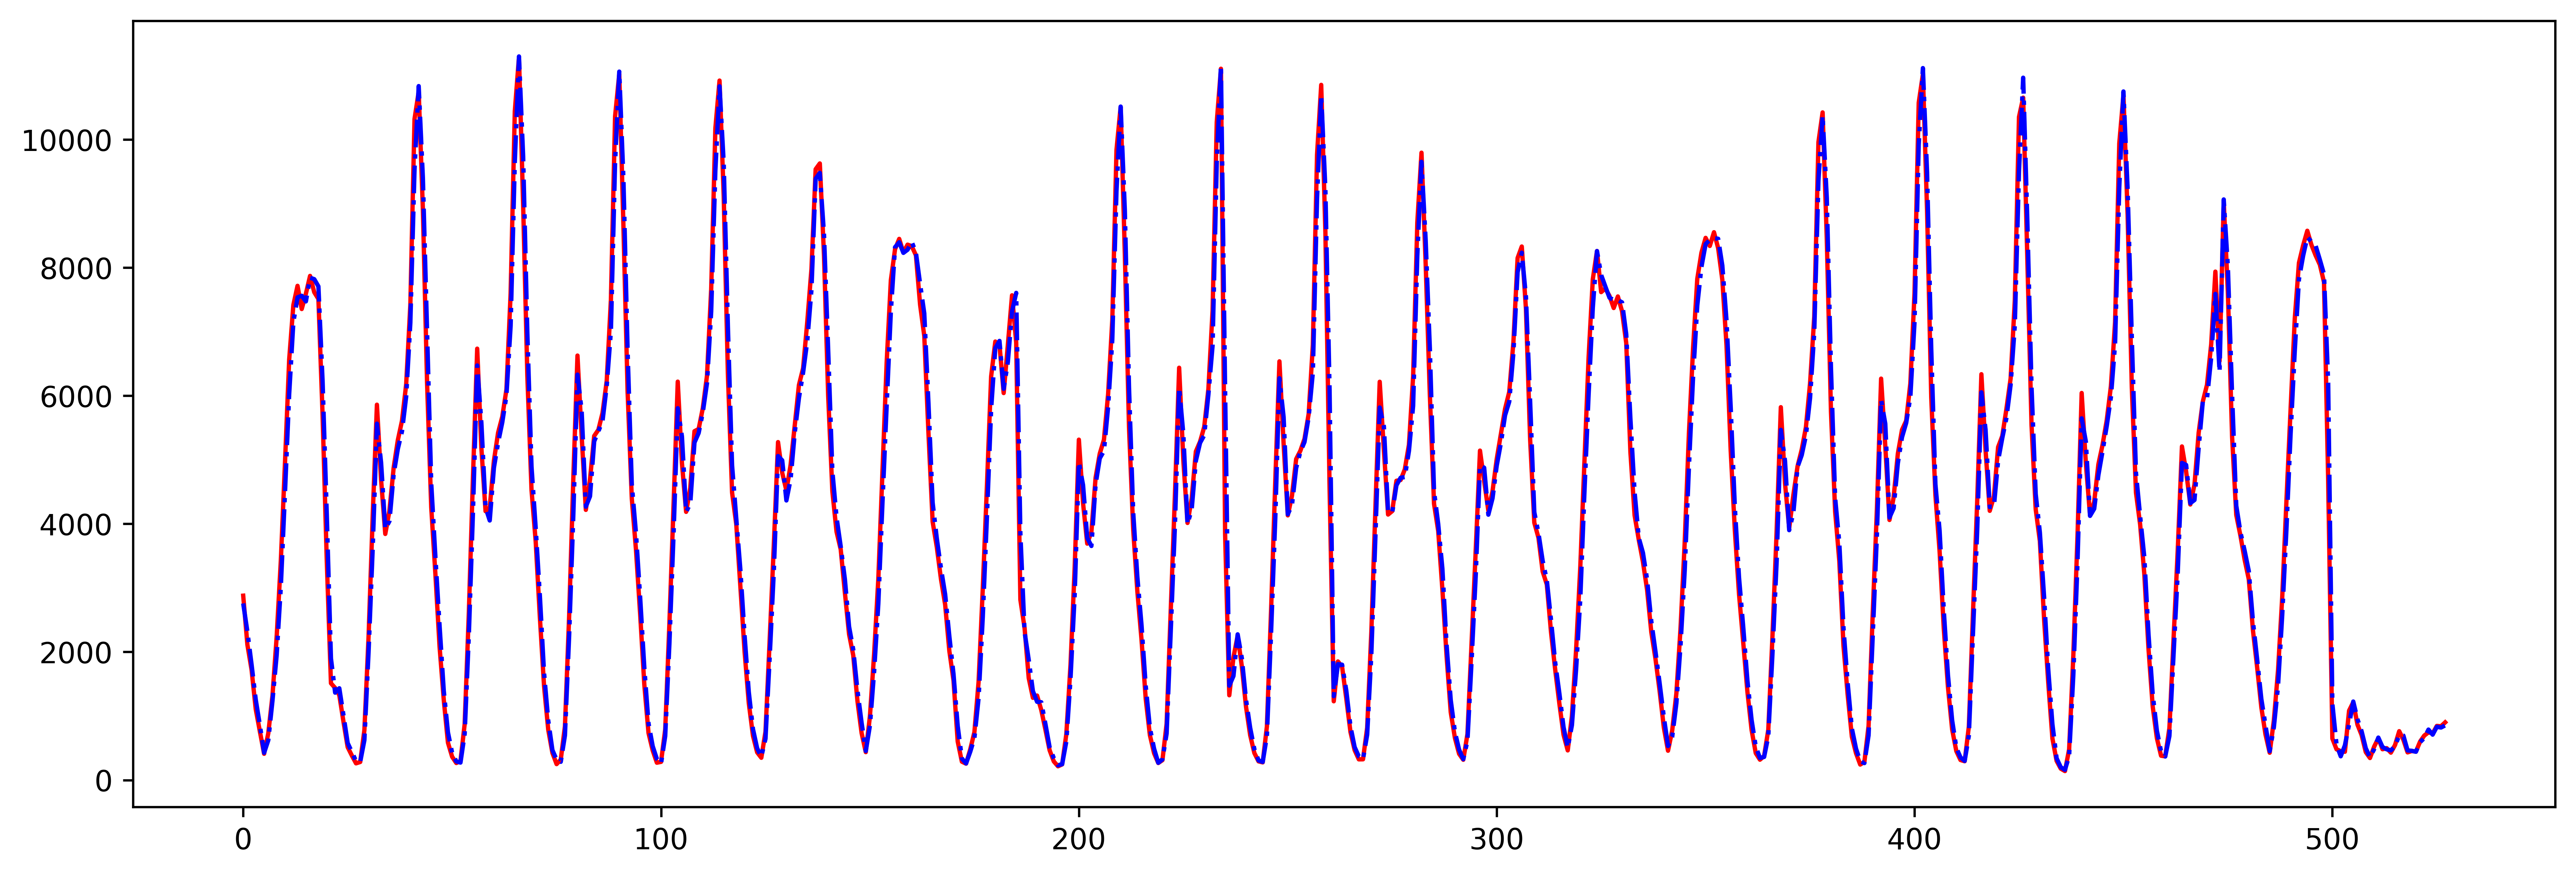

In [4]:
##### 1. 时间周期性
#-- 1.1 --  借车量 取8月1日——8月22日      ①每周的周期性    ② 22号是大雨季节
plt.figure(dpi=600,figsize=(15,5))
plt.plot(range(528),total_pick_per_hour['pick_num'][5088:5616],'r')
plt.plot(range(528),total_drop_per_hour['drop_num'][5088:5616],'b-.')

In [5]:
#-- 1.2 -- F检验 and T检验 p值
from scipy.stats import ttest_ind, f
def f_t_test(x,y):
    # 计算组内样本方差
    var1 = np.var(x, ddof=1)
    var2 = np.var(y, ddof=1)
    # 计算统计量F
    F = max(var1,var2) / min(var1,var2)
    # 计算自由度
    df1 = len(x) - 1
    df2 = len(y) - 1
    # 计算p值
    p_value = 1 - f.cdf(F, df2, df1)
    # T检验 的 p值
    t,p2 = ttest_ind(x,y, equal_var=True)
    return(str([p_value,p2]))
#-----------------------------------------    调用    ---------------------
temp = WEEKS_pick.columns
for i in range(0,4):
    for j in range(i+1,5):
        print(temp[i]+'-'+temp[j]+' '+f_t_test(WEEKS_pick[temp[i]],WEEKS_pick[temp[j]]))
print('星期6-星期7 '+f_t_test(WEEKS_pick[temp[5]],WEEKS_pick[temp[6]]))
# 周一到周五  周六和周日  见excel表格，由于一天内总借车量和还车量一般基本平衡，就这个结果对于借车和还车需求都一样可用

星期1-星期2 [0.3737685702825546, 0.2691749563071923]
星期1-星期3 [0.2400302517091506, 0.1483851188685579]
星期1-星期4 [0.16586687119059795, 0.29209868825521446]
星期1-星期5 [0.20579202386418105, 0.20661176210553328]
星期2-星期3 [0.35020928493470993, 0.7124467785608948]
星期2-星期4 [0.25792492372935794, 0.9979415686511575]
星期2-星期5 [0.30857867950049234, 0.8436128496277089]
星期3-星期4 [0.3953763385623844, 0.7266653632441908]
星期3-星期5 [0.4541278757477787, 0.8698449515723063]
星期4-星期5 [0.4403359614859348, 0.852374186684992]
星期6-星期7 [0.38020123906597103, 0.11154621462082735]


In [6]:
#-- 1.3 -- weekday和weekend分开的，以hour为单位的 数据
def day2hour(DandP,is_work):
    # 将 工作日 和 周末 分开
    total_DandP_workday = DandP
    if is_work == 1:
        total_DandP_workday = total_DandP_workday[total_DandP_workday['weekday'] != 6]
        total_DandP_workday = total_DandP_workday[total_DandP_workday['weekday'] != 7]
    else:
        for i in [1,2,3,4,5]:
            total_DandP_workday = total_DandP_workday[total_DandP_workday['weekday'] != i]

    # 为了给天气足够的训练数据，并且提升研究的精确度，把天气的影响从“天”缩小到“小时”粒度
    pick_per_hour = pd.DataFrame()
    for i in total_DandP_workday.index:
        temp = total_pick_per_hour[total_pick_per_hour['date'] == i]
        pick_per_hour = pd.concat([pick_per_hour,temp])
    return pick_per_hour
# -------------------------------------------------------调用函数
total_DandP_per_day =  pd.read_csv("C:/Users/83621/citibike1/total_DandP_per_day.csv",index_col=0)
work_per_hour = day2hour(total_DandP_per_day,1)
rest_per_hour = day2hour(total_DandP_per_day,0)
#删除无用变量
del total_pick_per_hour,total_drop_per_hour
del total_DandP_per_day,WEEKS_pick
work_per_hour.to_csv('C:/Users/83621/citibike1/work_per_hour.csv')
rest_per_hour.to_csv('C:/Users/83621/citibike1/rest_per_hour.csv')

In [7]:
##### 2. 空间相似性
#-- 2.1 -- 8月份借车量的热力图

N = pd.read_csv("C:/Users/83621/citibike1/ori_data/202108-citibike-tripdata.csv")[['start_station_id','start_station_name','start_lat','start_lng']]
# 获取站点id
temp = list(set(N['start_station_id']))
station_id = [x for x in temp if not(np.isnan(x))]

def get_locat(station_ID,lat_lon_name):
    temp = N[N['start_station_id']==station_ID]
    i = list(temp[lat_lon_name])[0] 
    return round(i,4)

NUM,LAN,LON = [],[],[]
for station in station_id:
    LAN.append(get_locat(station,'start_lat'))
    LON.append(get_locat(station,'start_lng'))
    NUM.append(len(N[N['start_station_id']==station]))
    
# 去量纲
A = []
for i in NUM:
    A.append((i-min(NUM))/13624)
# 构建画图矩阵    
DF=[]
for i in range(len(LON)):
    DF.append([LAN[i],LON[i],A[i]])
#-------------------------------------------------画图
from folium.plugins import HeatMap
m = folium.Map([ 40.75, -73.96], tiles='openstreetmap', zoom_start=5)
HeatMap(DF,radius=22,blur=15,dict={0.2: 'lightsteelblue', 0.4:'cornflowerblue',0.65: 'blue', 1: 'navy'}).add_to(m) 
m.save(os.path.join(r'C:\Users\83621\Desktop', 'Heatmap.html'))
m

In [8]:
#-- 2.2 -- 单车使用模式的k-means聚类图（一天之内需求量占比）

#数据准备
sta_picknum = pd.read_csv('C:/Users/83621/citibike1/sta_month82.csv',index_col=0)#表sta_month8是量，表sta_month82是占比
data_Array = sta_picknum.values
#for n in range(2,10):                                             #遍历不同k值下轮廓系数
#    print([n,Silhouette_ALL(data_Array,n)])

#聚类
estimator = skc.KMeans(n_clusters = 7)#构造聚类器
estimator.fit(data_Array)#聚类
lable = list(estimator.labels_)
# 画图
station_loc = (N[['start_station_name','start_lat','start_lng']]).dropna(axis=0, how='all')
station_loc = station_loc.drop_duplicates(subset=['start_station_name'], keep='first')
station_loc.index = station_loc['start_station_name']

color = ["green","red","blue","yellow","orange","brown","cyan","magenta","black"]
nyc_map = folium.Map(location=[40.655400,-73.976431],zoom_start=11,tiles='Stamen Toner')
for i in range(len(sta_picknum)):
    st_id = sta_picknum.index[i]
    for j in range(10):
        if lable[i] == j:
            folium.CircleMarker(location = [station_loc['start_lat'][st_id],station_loc[ 'start_lng'][st_id]],radius = 1.5, fill = True,color = color[j]).add_to(nyc_map)        
nyc_map

In [33]:
#-- 2.2 -- 单车使用模式的k-means聚类图（一天之内需求量占比）

#数据准备
sta_picknum = pd.read_csv('C:/Users/83621/citibike1/sta_month8.csv',index_col=0)#表sta_month8是量，表sta_month82是占比
data_Array = sta_picknum.values #data_Array = (sta_picknum.apply(lambda x:x.sum(),axis=1)).values
#聚类
estimator = skc.KMeans(n_clusters = 5)#构造聚类器
estimator.fit(data_Array)#聚类
lable = list(estimator.labels_)
# 画图
station_loc = (N[['start_station_name','start_lat','start_lng']]).dropna(axis=0, how='all')
station_loc = station_loc.drop_duplicates(subset=['start_station_name'], keep='first')
station_loc.index = station_loc['start_station_name']

color = ["green","red","blue","yellow","orange","brown","cyan","magenta","black"]
nyc_map = folium.Map(location=[40.655400,-73.976431],zoom_start=11,tiles='Stamen Toner')
for i in range(len(sta_picknum)):
    st_id = sta_picknum.index[i]
    for j in range(10):
        if lable[i] == j:
            folium.CircleMarker(location = [station_loc['start_lat'][st_id],station_loc[ 'start_lng'][st_id]],radius = 1.5, fill = True,color = color[j]).add_to(nyc_map)        
nyc_map

In [13]:
del N,NUM,LAN,LON,A,m,DF
del data_Array,station_loc,sta_picknum,estimator,lable,color,nyc_map